In [21]:
from lamr_ap_new import meanAP_LogAverageMissRate
from faster_eval import convert
import brambox.boxes as bbb

import os
import numpy as np
import scipy.interpolate
import json
import matplotlib.pyplot as plt


In [2]:
def convert_predict_to_JSON(input_path, output_path):
    # path_source = os.getcwd()
#     path_source = 'results'

#     filename = 'det_test_person.txt'

#     desname = 'detection_results.json'
#     if not os.path.exists(path_source):
#         print('Error: No exits source folder')
#         sys.exit()
    # os.chdir(path_source)

    f = open(os.path.join(input_path),'r')
    lines = f.readlines()
    f.close()

    allscore = []
    alldata = []

    for line in lines:
        if len(line) > 1 or line != '\n':
            listdata = line.split(' ')
            imageID = listdata[0]
            confscore = float(listdata[1])
            left = float(listdata[2])
            top = float(listdata[3])
            right = float(listdata[4])
            bottom = float(listdata[5])
            allscore.append(confscore)

            ###this is only for KAIST dataset.
#            imageID = imageID.replace('V','/V').replace('visible','/').replace('lwir','/').replace('_','')
            imageID = imageID.replace('V','/V').replace('I','/I').replace('visible','').replace('lwir','').replace('_','')

            alldata.append({
                'image_id':imageID,
                'category_id':1,
                'bbox': [left,top,right-left,bottom-top],
                'score':confscore,
            })
    with open(os.path.join(output_path), 'w') as outfile:
        json.dump(alldata, outfile,ensure_ascii=True)

## convert to json (do once)

In [3]:
output_path = '/home/superorange5/Research/KAIST_research/task-conditioned/results/KAIST/'
input_path = '/home/superorange5/Research/2019_deepMI3/deepMI3/faster-RCNN/output'
#convert_det_result_list = ['AVG_cr','AVG_cd','AVG_rd','wkAVG_cr','wkAVG_cd','wkAVG_rd']
convert_det_result_list = ['fasterCR','fasterCD','fasterRD']
i = 30
#wkAVG_cr   AVG_cr   fasterCR
#model_subfolder = 'AVG_cr' #'KAIST_fasterRCNN_vgg16_FedAvg_AVG'
for model_subfolder in convert_det_result_list:
    input_folder = os.path.join(input_path, model_subfolder,'KAIST_fasterRCNN_vgg16_'+str(i),'detection_results/')
    #input_folder = os.path.join(input_path, model_subfolder,'KAIST_fasterRCNN_vgg16-AVG_'+str(i),'detection_results/')
    output_txt = os.path.join(output_path,model_subfolder+'.txt')
    output_json = os.path.join(output_path,model_subfolder+'.json')

    convert(input_folder, output_txt)
    convert_predict_to_JSON(output_txt, output_json)



In [23]:
input_json = 'results/KAIST/AVG_cd.json'
detections_all, AVG_CD_campus, AVG_CD_road, AVG_CD_downtown = meanAP_LogAverageMissRate(input_json)

In [24]:
input_json = 'results/KAIST/AVG_cr.json'
detections_all, AVG_CR_campus, AVG_CR_road, AVG_CR_downtown = meanAP_LogAverageMissRate(input_json)

In [25]:
input_json = 'results/KAIST/AVG_rd.json'
detections_all, AVG_RD_campus, AVG_RD_road, AVG_RD_downtown = meanAP_LogAverageMissRate(input_json)

In [26]:
input_json = 'results/KAIST/wkAVG_cd.json'
detections_all, wkAVG_CD_campus, wkAVG_CD_road, wkAVG_CD_downtown = meanAP_LogAverageMissRate(input_json)

In [27]:
input_json = 'results/KAIST/wkAVG_cr.json'
detections_all, wkAVG_CR_campus, wkAVG_CR_road, wkAVG_CR_downtown = meanAP_LogAverageMissRate(input_json)

In [28]:
input_json = 'results/KAIST/wkAVG_rd.json'
detections_all, wkAVG_RD_campus, wkAVG_RD_road, wkAVG_RD_downtown = meanAP_LogAverageMissRate(input_json)

In [29]:
input_json = 'results/KAIST/fasterCD.json'
detections_all, faster_CD_campus, faster_CD_road, faster_CD_downtown = meanAP_LogAverageMissRate(input_json)

In [30]:
input_json = 'results/KAIST/fasterCR.json'
detections_all, faster_CR_campus, faster_CR_road, faster_CR_downtown = meanAP_LogAverageMissRate(input_json)

In [31]:
input_json = 'results/KAIST/fasterRD.json'
detections_all, faster_RD_campus, faster_RD_road, faster_RD_downtown = meanAP_LogAverageMissRate(input_json)

### GT

In [5]:
    identify = lambda f: os.path.splitext("/".join(f.rsplit('/')[-3:]))[0]

    ground_truth = bbb.parse('anno_dollar', 'annotations/*/*/*.txt', identify, occlusion_tag_map=[0.0, 0.25, 0.75])
    # print(len(ground_truth))
    # print(identify)
    # filter ground truth by marking boxes with the ignore flag
    bbb.filter_ignore(ground_truth, [bbb.ClassLabelFilter(['person']),  # only consider 'person' objects
                                     bbb.HeightRangeFilter((50, float('Inf'))),  # select instances of 50 pixels or higher
                                     bbb.OcclusionAreaFilter(
                                         (0.65, float('Inf')))])  # only include objects that are 65% visible or more

    for _, annos in ground_truth.items():
        for i in range(len(annos)):
            annos[i].class_label = 'person'

    # modify ground truth aspect ratio
    bbb.modify(ground_truth, [bbb.AspectRatioModifier(.41, modify_ignores=False)]);

    ground_truth_campus = {key: values for key, values in ground_truth.items() if
                        key.startswith('set06') or key.startswith('set09') }

    ground_truth_road = {key: values for key, values in ground_truth.items() if
                        key.startswith('set07') or key.startswith('set10')}

    ground_truth_downtown = {key: values for key, values in ground_truth.items() if
                        key.startswith('set08') or key.startswith('set11') }

In [6]:

    def lamr(miss_rate, fppi, num_of_samples=9):
        """ Compute the log average miss-rate from a given MR-FPPI curve.
        The log average miss-rate is defined as the average of a number of evenly spaced log miss-rate samples
        on the :math:`{log}(FPPI)` axis within the range :math:`[10^{-2}, 10^{0}]`

        Args:
            miss_rate (list): miss-rate values
            fppi (list): FPPI values
            num_of_samples (int, optional): Number of samples to take from the curve to measure the average precision; Default **9**

        Returns:
            Number: log average miss-rate
        """
        samples = np.logspace(-2., 0., num_of_samples)
        m = np.array(miss_rate)
        f = np.array(fppi)
        interpolated = scipy.interpolate.interp1d(f, m, fill_value=(1., 0.), bounds_error=False)(samples)
        #     print('interpolated: ')
        #     print(interpolated)
        for i, value in enumerate(interpolated):
            if value <= 0:
                interpolated[i] = interpolated[i - 1]

        log_interpolated = np.log(interpolated)
        avg = sum(log_interpolated) / len(log_interpolated)
        return np.exp(avg)


In [67]:


def getCurves(result_list, ground_truth):
    label_list = ['faster RCNN', 'FedAvg','FedWCD_guided']


    colors = ['#6EB5FF', '#FF8B21',  '#6AA160']
    linestyles = ['-', '--', '-.', ':']
    curves_list = []
    for idx, results in enumerate(result_list):
        #ground_truth = ground_truth_list[idx]
        curves = []
        scores = {}
        # colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        #     colors = ['#1919ff', '#ff7f0e', '#ff1919', '#ff19ff', '#19ff19', '#19ff19']



        for label, detections in results.items():
            ### because YOLO has stuck in small object, so the paper of this code on CVPRW prefer chose overlap 0.4, but here we choose 0.5 for all.
            #         if label=='YOLO_TLV' or label=='Ours: TD(V,V)' or label=='Ours: TD(T,T)' or label=='Ours: TD(VT,T)' or label=='Ours: BU(VAT,T)' or label == 'Ours: BU(VLT,T)':
            #             print(label)
            #             overlap = 0.4

            ys, xs = bbb.mr_fppi(detections, ground_truth, overlap)
            score = round(lamr(ys, xs) * 100, 2)

            color = colors[idx % len(colors)]
            linestyle = linestyles[idx % len(linestyles)]


            curves += [(label_list[idx], ys, xs, score, color, linestyle)]
            scores[label] = score

        # sort from lowest to highest
        sorted_curves = sorted(curves, key=lambda curve: curve[3])
        curves_list.append(sorted_curves)

    return curves_list     



In [69]:
def plot_fig(curves_list, title, savename, overlap=0.5, only_plot=['current'], linewidth = 2, figsize=(8,6), legendloc=3):
    fig, ax = plt.subplots(figsize=figsize)

    for sort_curves in curves_list:
        label = sort_curves[0][0]
        ys = sort_curves[0][1]
        xs = sort_curves[0][2]
        score = sort_curves[0][3]
        color = sort_curves[0][4]
        linestyle = sort_curves[0][5]




        plt.loglog(xs, ys, color=color, linestyle=linestyle, label=f"{score}%  {label}", linewidth=linewidth)
    plt.legend(loc=legendloc)

    plt.gcf().suptitle(title, weight='bold')

    from matplotlib.ticker import FormatStrFormatter, LogLocator
    subs = [1.0, 2.0, 3.0, 4.0, 5.0, 6.4, 8.0]  # ticks to show per decade
    ax.yaxis.set_minor_locator(LogLocator(subs=subs))
    ax.yaxis.set_minor_formatter(FormatStrFormatter("%.2f"))
    ax.yaxis.grid(which='minor')
    ax.xaxis.grid(which='major')
    plt.setp(ax.get_ymajorticklabels(), visible=False)  # disable major labels

    plt.gca().set_ylabel('Miss rate')
    plt.gca().set_xlabel('FPPI')
    plt.gca().set_ylim([0.3, 1])

    plt.gca().set_xlim([0, 5])
    plt.savefig(savename, transparent=True)

/work/superorange5/anaconda2/envs/pygrid/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


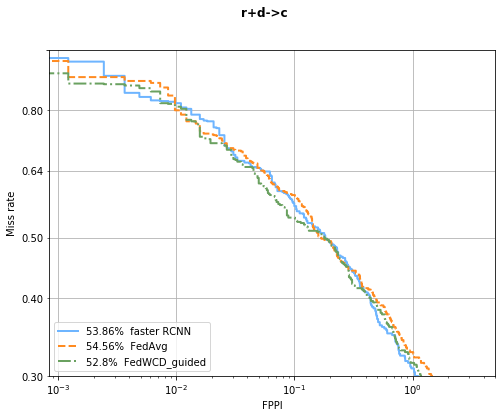

In [72]:
title="r+d->c"
savename = 'rdc.png' 
result_list  = [faster_RD_campus, AVG_RD_campus, wkAVG_RD_campus ]
ground_truth = ground_truth_campus

curves_list = getCurves(result_list, ground_truth)
plot_fig(curves_list, title, savename)

/work/superorange5/anaconda2/envs/pygrid/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


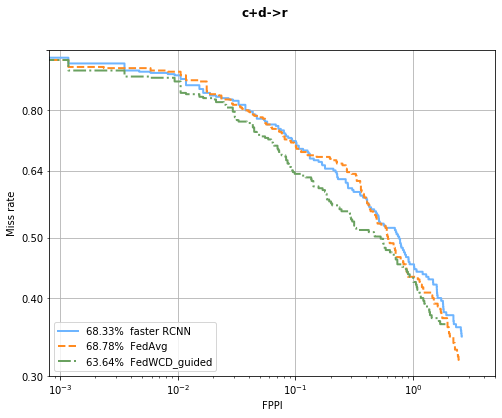

In [73]:
title="c+d->r"
savename = 'cdr.png' 
result_list  = [faster_CD_road, AVG_CD_road, wkAVG_CD_road ]
ground_truth = ground_truth_road

curves_list = getCurves(result_list, ground_truth)
plot_fig(curves_list, title, savename)

/work/superorange5/anaconda2/envs/pygrid/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


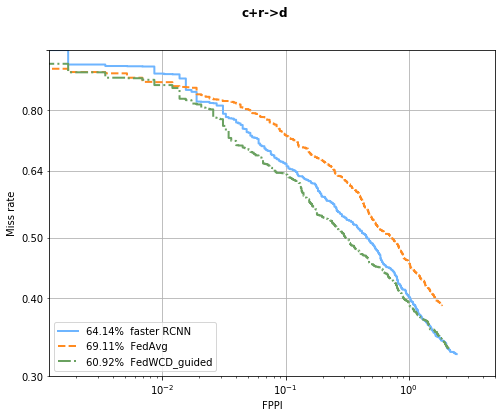

In [74]:
title="c+r->d"
savename = 'crd.png' 
result_list  = [faster_CR_downtown, AVG_CR_downtown, wkAVG_CR_downtown ]
ground_truth = ground_truth_downtown

curves_list = getCurves(result_list, ground_truth)
plot_fig(curves_list, title, savename)